This script is designed to take the electromagnetic field data from 1D PIC simulations and recover four time-series.

In [16]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.fft import fft, ifft

In [60]:
def winSincFilter(m,cutoff,window='Hamming',btype='bandpass'):
    '''
    Create filter kernel for a windowed sinc filter.

    "Windowed-sinc filters are used to separate one band of frequencies from another. 
    They are very stable, produce few surprises, and can be pushed to incredible performance levels."

    Reference
    ---------
    http://www.dspguide.com/ch16/1.htm
    
    Parameters
    ----------
    m: length of the filter kernel (must be an even integer)
    cutoff : array of cut-off frequencies normalised to the Nyquist frequency
    window : window function (Hamming or Blackman)
    btype: type of filter: 'bandpass'
    
    Returns
    -------
    Array of filter coefficients
    
    '''
    
    if m % 2 == 0:
            ts = np.arange(-m/2,m/2)
    
    # un-normalise the cutoff frequencies
    dt = ts[1]-ts[0]
    omegaNyq = np.pi / dt
    #print(omegaNyq)
    cutoff = omegaNyq*np.asarray(cutoff)    

    if window == 'Hamming':
        win = 0.54 - 0.46*np.cos(2*np.pi*ts/m)
    elif window == 'Blackman':
        win = 0.42 - 0.5*np.cos(2*np.pi*ts/m) + 0.08*cos(4*np.pi*ts/m)
    else:
        win = 1
        
    if btype == 'bandpass':
        # construct low-pass for the upper cut-off
        lp = cutoff[1]*np.sinc(cutoff[1]*ts)
        # construct high-pass for the lower cut-off
        hp = -1*cutoff[0]*np.sin(cutoff[0]*ts)
        # combine to make a bandpass
        b = lp + hp
        # correct centre of kernel
        b[m//2] += 1.0
        
    # do windowing
    b *= win
    
    # scale so the gain is 1.0 at the pass frequency
    if btype == 'bandpass':
        scale_frequency = 0.5 * (cutoff[0]+cutoff[1])
    b /= scale_frequency
        
    plt.plot(ts,b)
    plt.show()
    
    return b

#winSincFilter(m=100,cutoff=[0.85,1.25],window='Hamming',btype='bandpass')

We now define a test problem which will allow us to compare different filters

115.0 85.0
400.0


(0.0, 150.0)

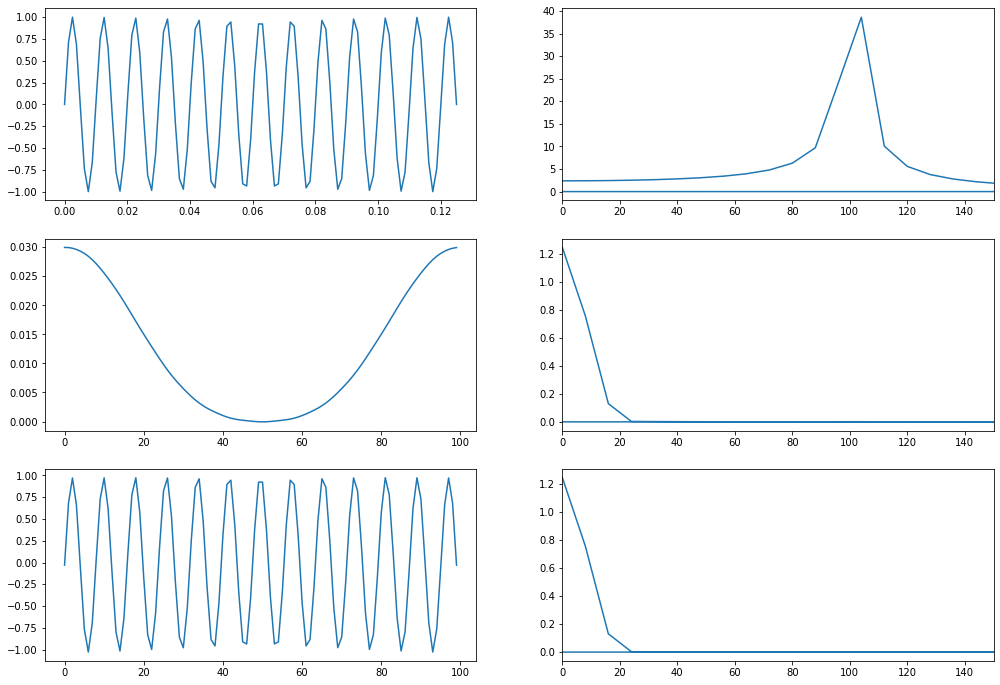

In [84]:
# construct an example signal
N = 100 # number of sample points
dt = 1.0 / 800 # sample spacing
t = np.linspace(0.0,N*dt,N)
laser_freq = 100
scatter_freq = 60
sig = np.sin(2*np.pi*laser_freq*t) #+ 0.5*np.sin(2*np.pi*scatter_freq*t)

# check fourier spectrum
fftsig = fft(sig)
fft_fre = np.fft.fftfreq(N,dt)

# try scipy FIR filter
bw = 30
ub = (laser_freq + bw/2)
lb = (laser_freq - bw/2)
print(ub,lb)
nyq = 1/dt / 2
print(nyq)
band_pass = signal.firwin(100,[2*np.pi*lb/nyq,2*np.pi*ub/nyq],pass_zero='bandpass',window='blackman',fs=1/dt)
laser_sig = np.convolve(sig,band_pass,mode='same')

# plot the signal and its Fourier transform
fig,ax = plt.subplots(3,2,figsize=(17,12))
ax[0,0].plot(t,sig)
ax[0,1].plot(fft_fre,np.abs(fftsig))
ax[0,1].set_xlim(0,150)

ax[1,0].plot(laser_sig)
ax[1,1].plot(fft_fre,np.abs(fft(laser_sig)))
ax[1,1].set_xlim(0,150)


ax[2,0].plot(sig-laser_sig)
ax[2,1].plot(fft_fre,np.abs(fft(laser_sig)))
ax[2,1].set_xlim(0,150)

(0.0, 100.0)

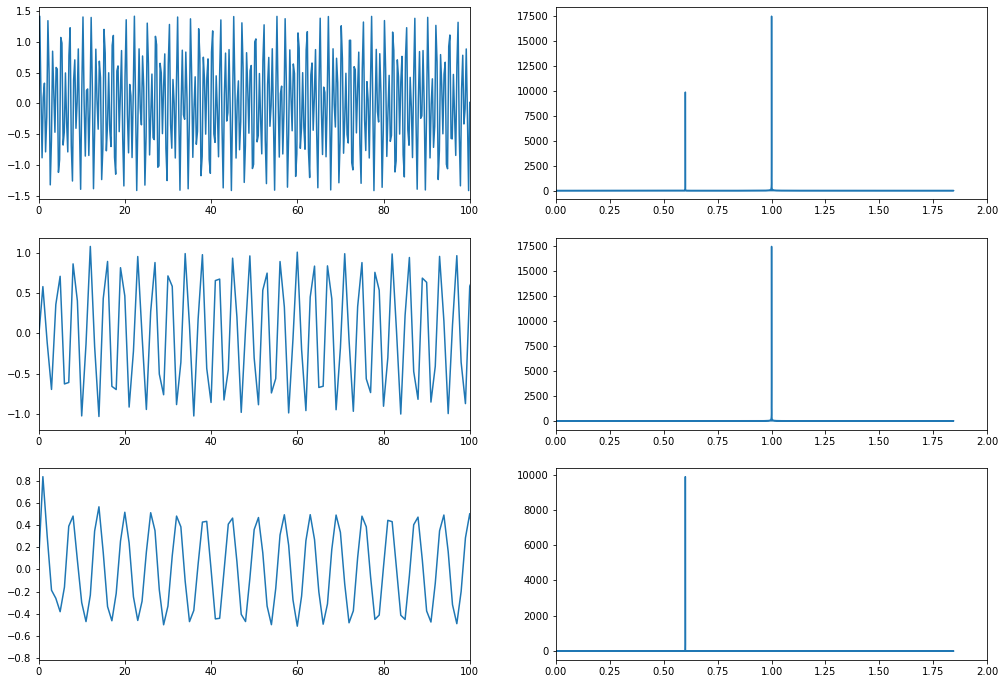

In [100]:
# Example code, computes the coefficients of a band-pass windowed-sinc filter.

# Configuration.
fS = 3.69  # Sampling rate.
fL = 0.85  # Cutoff frequency.
fH = 1.15  # Cutoff frequency.
NL = 461  # Filter length for roll-off at fL, must be odd.
NH = 461  # Filter length for roll-off at fH, must be odd.

# Compute a low-pass filter with cutoff frequency fH.
hlpf = np.sinc(2 * fH / fS * (np.arange(NH) - (NH - 1) / 2))
hlpf *= np.blackman(NH)
hlpf /= np.sum(hlpf)

# Compute a high-pass filter with cutoff frequency fL.
hhpf = np.sinc(2 * fL / fS * (np.arange(NL) - (NL - 1) / 2))
hhpf *= np.blackman(NL)
hhpf /= np.sum(hhpf)
hhpf = -hhpf
hhpf[(NL - 1) // 2] += 1

# Convolve both filters.
h = np.convolve(hlpf, hhpf)

# Applying the filter to a signal s can be as simple as writing
# s = np.convolve(s, h)

# construct a test signal
N = 39605 # number of sample points
t = np.linspace(0,10733,39605)
laser_freq = 1
scatter_freq = 0.6
sig = np.sin(2*np.pi*laser_freq*t) + 0.5*np.sin(2*np.pi*scatter_freq*t)

# plot the signal and its Fourier transform
fig,ax = plt.subplots(3,2,figsize=(17,12))
ax[0,0].plot(t,sig)
fftsig = fft(sig)
fft_fre = np.fft.fftfreq(N,1/fS)
ax[0,1].plot(fft_fre,np.abs(fftsig))
ax[0,1].set_xlim(0,2)
ax[0,0].set_xlim(0,100)

laser_sig = np.convolve(sig,h,mode='same')
ax[1,0].plot(laser_sig)
ax[1,1].plot(fft_fre,np.abs(fft(laser_sig)))
ax[1,1].set_xlim(0,2)
ax[1,0].set_xlim(0,100)

scatter_sig = sig - laser_sig
ax[2,0].plot(sig-laser_sig)
ax[2,1].plot(fft_fre,np.abs(fft(scatter_sig)))
ax[2,1].set_xlim(0,2)
ax[2,0].set_xlim(0,100)